# ETA Prediction Model - XGBoost with SHAP

Predicting delivery ETAs using XGBoost and explaining predictions with SHAP for business insights.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import shap
import warnings
import os
import sys

# Add parent directory to path to import from src if needed
sys.path.append('..')
sys.path.append('../src')

warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load Processed Data


In [2]:
# Load processed features and target (path relative to notebook location)
X = pd.read_csv('../outputs/data/processed_features.csv')
y = pd.read_csv('../outputs/data/target.csv')['hours_until_delivery']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget statistics:")
print(y.describe())


Features shape: (72766, 3368)
Target shape: (72766,)

Target statistics:
count    72766.000000
mean        98.130762
std         64.873132
min         -6.000000
25%         48.000000
50%         92.000000
75%        136.000000
max       2368.000000
Name: hours_until_delivery, dtype: float64


## 2. Chronological Train-Test Split

Split data chronologically (by time) to ensure training on past data and testing on future data.


In [3]:
# Chronological split: Use earlier data for training, later data for testing
# Load the actual_ship dates that were saved during ETL
try:
    ship_dates = pd.read_csv('../outputs/data/actual_ship_dates.csv')
    ship_dates['actual_ship'] = pd.to_datetime(ship_dates['actual_ship'])
    print("Loaded ship dates from ETL output")
except:
    # Fallback: load and process original data
    print("Loading original data to get ship dates...")
    df_with_dates = pd.read_csv('../Dataset/last-mile-data.csv')
    df_with_dates['actual_ship'] = pd.to_datetime(df_with_dates['actual_ship'])
    df_with_dates = df_with_dates[df_with_dates['actual_transit_days'] >= 0].copy()
    df_with_dates = df_with_dates[df_with_dates['customer_distance'] > 0].copy()
    df_with_dates = df_with_dates.sort_values('actual_ship').reset_index(drop=True)
    ship_dates = df_with_dates[['actual_ship']].copy()

# Ensure we have the same number of rows
min_len = min(len(X), len(ship_dates))
X = X.iloc[:min_len].copy()
y = y.iloc[:min_len].copy()
ship_dates = ship_dates.iloc[:min_len].copy()

# Get sort indices based on actual_ship date
sort_indices = ship_dates['actual_ship'].argsort().values

# Reorder X and y to match chronological order
X_sorted = X.iloc[sort_indices].reset_index(drop=True)
y_sorted = y.iloc[sort_indices].reset_index(drop=True)
ship_dates_sorted = ship_dates.iloc[sort_indices].reset_index(drop=True)

print(f"Data sorted chronologically")
print(f"Date range: {ship_dates_sorted['actual_ship'].min()} to {ship_dates_sorted['actual_ship'].max()}")

# Split chronologically (80% for training, 20% for testing)
split_idx = int(len(X_sorted) * 0.8)

X_train = X_sorted.iloc[:split_idx].copy()
X_test = X_sorted.iloc[split_idx:].copy()
y_train = y_sorted.iloc[:split_idx].copy()
y_test = y_sorted.iloc[split_idx:].copy()

print(f"\nChronological Split:")
print(f"Training set: {X_train.shape[0]:,} samples (earlier data)")
print(f"Test set: {X_test.shape[0]:,} samples (later data)")
print(f"\nDate range check:")
print(f"Training period: {ship_dates_sorted.iloc[:split_idx]['actual_ship'].min()} to {ship_dates_sorted.iloc[:split_idx]['actual_ship'].max()}")
print(f"Test period: {ship_dates_sorted.iloc[split_idx:]['actual_ship'].min()} to {ship_dates_sorted.iloc[split_idx:]['actual_ship'].max()}")


Loaded ship dates from ETL output
Data sorted chronologically
Date range: 2022-01-03 10:00:00 to 2025-08-29 18:00:00

Chronological Split:
Training set: 58,212 samples (earlier data)
Test set: 14,554 samples (later data)

Date range check:
Training period: 2022-01-03 10:00:00 to 2024-10-29 09:00:00
Test period: 2024-10-29 10:00:00 to 2025-08-29 18:00:00


## 3. Train XGBoost Model


In [4]:
# Check for GPU availability and XGBoost GPU support
import subprocess
gpu_available = True
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=5)
    gpu_available = result.returncode == 0
    # Also check if XGBoost has GPU support
    try:
        import xgboost as xgb_test
        # Try to create a simple model with GPU to test
        test_params = {'tree_method': 'hist', 'device': 'cuda'}
        # If this doesn't error, GPU might be available
    except:
        gpu_available = False
except:
    gpu_available = False

# XGBoost model - use CPU for now (GPU support requires special XGBoost build)
# For hackathon, CPU is fine and more reliable
print("Using CPU for XGBoost training (more reliable for hackathon)...")
print("Note: For GPU support, install xgboost with: pip install xgboost[gpu]")

model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',  # Use hist for speed, works on CPU
    device='cpu'  # Explicitly set to CPU
)

print("Training XGBoost model...")
model.fit(X_train, y_train)
print("Training complete!")


Using CPU for XGBoost training (more reliable for hackathon)...
Note: For GPU support, install xgboost with: pip install xgboost[gpu]
Training XGBoost model...
Training complete!


## 4. Model Evaluation - Regression Metrics


In [5]:
# Predictions (store full test predictions for later use)
y_train_pred = model.predict(X_train)
y_test_pred_full = model.predict(X_test)
y_test_pred = y_test_pred_full  # Use full predictions

# Regression metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Regression Metrics:")
print("=" * 60)
print(f"{'Metric':<20s} {'Train':<15s} {'Test':<15s}")
print("-" * 60)
print(f"{'MAE (hours)':<20s} {train_mae:<15.2f} {test_mae:<15.2f}")
print(f"{'RMSE (hours)':<20s} {train_rmse:<15.2f} {test_rmse:<15.2f}")
print(f"{'R² Score':<20s} {train_r2:<15.4f} {test_r2:<15.4f}")
print("=" * 60)


Regression Metrics:
Metric               Train           Test           
------------------------------------------------------------
MAE (hours)          19.72           18.60          
RMSE (hours)         38.49           31.71          
R² Score             0.6717          0.6639         


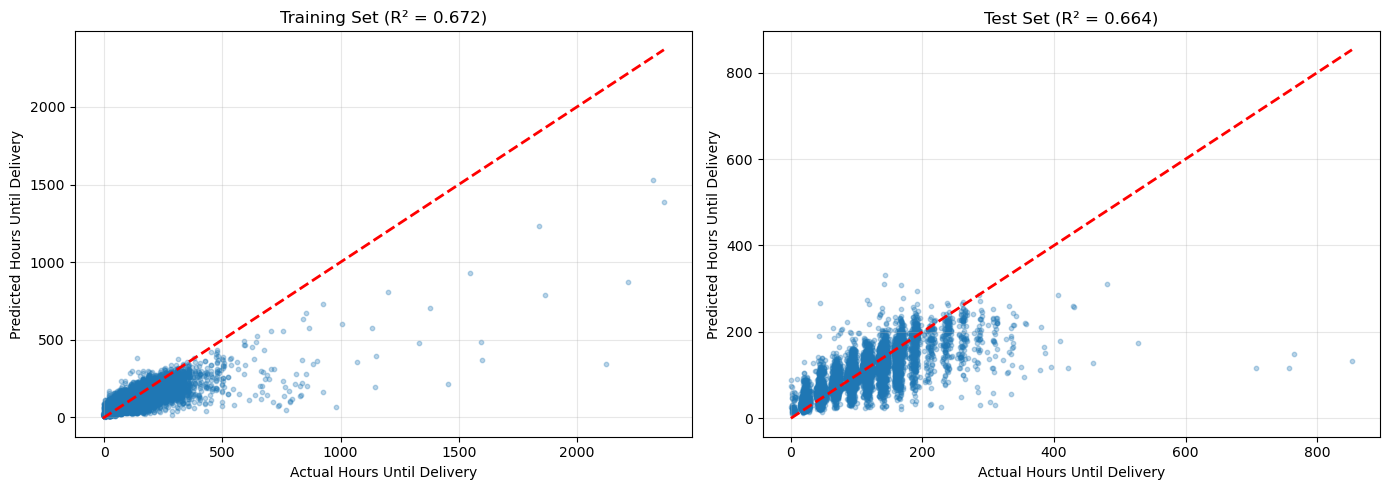

In [6]:
# Visualize predictions vs actual
os.makedirs('../outputs/graphs', exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.3, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Hours Until Delivery')
axes[0].set_ylabel('Predicted Hours Until Delivery')
axes[0].set_title(f'Training Set (R² = {train_r2:.3f})')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.3, s=10)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Hours Until Delivery')
axes[1].set_ylabel('Predicted Hours Until Delivery')
axes[1].set_title(f'Test Set (R² = {test_r2:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/graphs/predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()


## 5. Model Evaluation - OTD Classification Metrics

Note: To calculate OTD metrics, we need the goal transit days. Since we don't have that in the processed features (to avoid leakage), we'll need to load it separately or use a threshold.


In [7]:
# Load original data to get goal transit days for OTD evaluation
# Since we're using chronological split, we can match by the sorted order
df_original = pd.read_csv('../Dataset/last-mile-data.csv')
df_original['actual_ship'] = pd.to_datetime(df_original['actual_ship'])
df_original['actual_delivery'] = pd.to_datetime(df_original['actual_delivery'])

# Clean same way as ETL
df_original = df_original[df_original['actual_transit_days'] >= 0].copy()
df_original = df_original[df_original['customer_distance'] > 0].copy()
df_original = df_original.sort_values('actual_ship').reset_index(drop=True)

# Get goal transit days for test set
# Since we sorted chronologically, the test set corresponds to the later portion
# of the sorted original data
test_start_idx = split_idx  # This matches the chronological split
test_end_idx = min(len(df_original), test_start_idx + len(X_test))
goal_transit_days = df_original.iloc[test_start_idx:test_end_idx]['all_modes_goal_transit_days'].values

# Ensure same length (in case of any misalignment)
min_test_len = min(len(y_test), len(goal_transit_days), len(y_test_pred))
goal_transit_days = goal_transit_days[:min_test_len]
y_test_subset = y_test.iloc[:min_test_len]
y_test_pred_subset = y_test_pred[:min_test_len]

# Convert predictions to days (using subset for OTD metrics)
predicted_days = y_test_pred_subset / 24
actual_days = y_test_subset.values / 24

# Calculate OTD metrics
def calculate_otd_metrics(predicted_days, actual_days, goal_days):
    """Calculate on-time delivery metrics"""
    # Predicted OTD
    pred_early = (predicted_days < goal_days).sum()
    pred_on_time = (predicted_days == goal_days).sum()
    pred_late = (predicted_days > goal_days).sum()
    
    # Actual OTD
    actual_early = (actual_days < goal_days).sum()
    actual_on_time = (actual_days == goal_days).sum()
    actual_late = (actual_days > goal_days).sum()
    
    total = len(goal_days)
    
    return {
        'predicted': {
            'early_rate': pred_early / total * 100,
            'on_time_rate': pred_on_time / total * 100,
            'late_rate': pred_late / total * 100
        },
        'actual': {
            'early_rate': actual_early / total * 100,
            'on_time_rate': actual_on_time / total * 100,
            'late_rate': actual_late / total * 100
        }
    }

otd_metrics = calculate_otd_metrics(predicted_days, actual_days, goal_transit_days)

print("OTD Classification Metrics (Test Set):")
print("=" * 70)
print(f"{'Metric':<25s} {'Predicted':<20s} {'Actual':<20s}")
print("-" * 70)
print(f"{'Early Rate (%)':<25s} {otd_metrics['predicted']['early_rate']:<20.2f} {otd_metrics['actual']['early_rate']:<20.2f}")
print(f"{'On-Time Rate (%)':<25s} {otd_metrics['predicted']['on_time_rate']:<20.2f} {otd_metrics['actual']['on_time_rate']:<20.2f}")
print(f"{'Late Rate (%)':<25s} {otd_metrics['predicted']['late_rate']:<20.2f} {otd_metrics['actual']['late_rate']:<20.2f}")
print("=" * 70)


OTD Classification Metrics (Test Set):
Metric                    Predicted            Actual              
----------------------------------------------------------------------
Early Rate (%)            26.59                34.24               
On-Time Rate (%)          0.00                 1.17                
Late Rate (%)             73.41                64.59               


## 6. Feature Importance


Top 20 Most Important Features:
carrier_pseudo_dbfc03065eae                       : 0.0437
carrier_posted_service_days                       : 0.0244
lane_avg_transit_days                             : 0.0198
all_modes_goal_transit_days                       : 0.0171
ship_day_of_week                                  : 0.0151
dest_zip_3d_331xx                                 : 0.0144
lane_zip3_pair_750xx→874xx                        : 0.0134
lane_zip3_pair_441xx→030xx                        : 0.0130
dest_zip_3d_524xx                                 : 0.0124
lane_id_dbda9f649e43                              : 0.0121
lane_id_f3985f621dda                              : 0.0116
dest_zip_3d_288xx                                 : 0.0108
lane_zip3_pair_750xx→804xx                        : 0.0099
dest_zip_3d_585xx                                 : 0.0092
lane_zip3_pair_US→US                              : 0.0090
lane_id_72222c324e93                              : 0.0090
lane_id_390bff0cff51    

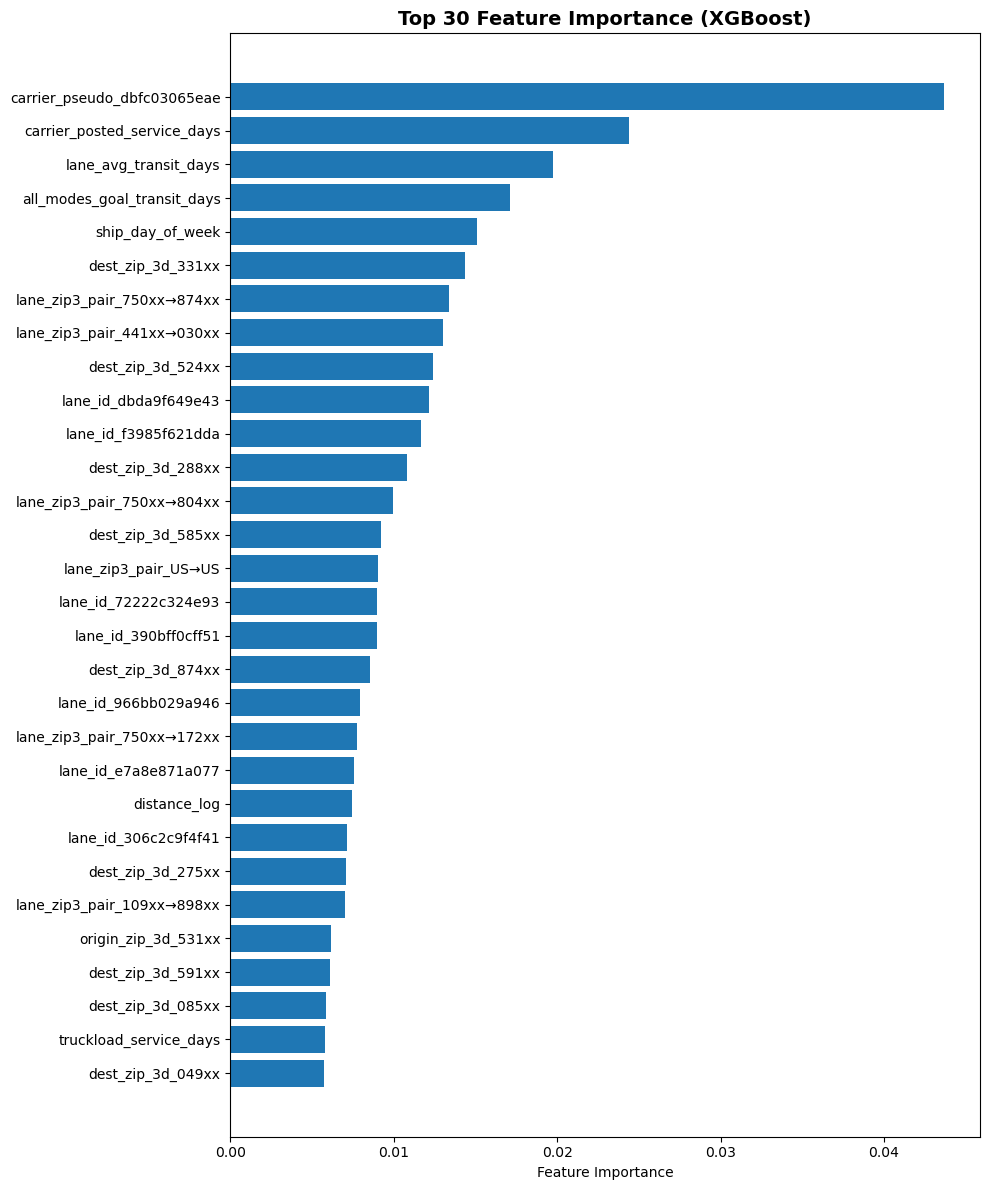


Model saved to ../outputs/models/xgboost_model.pkl


In [8]:
# Get feature importance from XGBoost
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print("=" * 60)
for idx, row in feature_importance.head(20).iterrows():
    print(f"{row['feature']:50s}: {row['importance']:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 12))
top_30 = feature_importance.head(30)
plt.barh(range(len(top_30)), top_30['importance'].values)
plt.yticks(range(len(top_30)), top_30['feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 30 Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../outputs/graphs/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
os.makedirs('../outputs/models', exist_ok=True)
import pickle
with open('../outputs/models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("\nModel saved to ../outputs/models/xgboost_model.pkl")


## 7. SHAP Analysis


In [10]:
# Feature Importance using Permutation Importance
# (More reliable than SHAP with XGBoost 2.x compatibility issues)
from sklearn.base import clone
from tqdm.auto import tqdm
import pickle
import time

# Path for saved importance values
importance_save_path = '../outputs/models/feature_importance_results.pkl'

# Check if we have saved results
SKIP_IMPORTANCE = os.path.exists(importance_save_path)

if SKIP_IMPORTANCE:
    print("Loading saved feature importance results...")
    with open(importance_save_path, 'rb') as f:
        importance_results = pickle.load(f)
    perm_importance = importance_results['permutation_importance']
    feature_names = importance_results['feature_names']
    print(f"✅ Loaded importance for {len(feature_names)} features")
else:
    print("Computing permutation-based feature importance...")
    print("This provides feature contributions similar to SHAP but is more compatible.\n")
    
    # Prepare data
    X_test_subset = X_test[:1000].values if len(X_test) > 1000 else X_test.values
    y_test_subset = y_test.iloc[:1000].values if len(y_test) > 1000 else y_test.values
    feature_names = X_test.columns.tolist()
    n_features = len(feature_names)
    n_repeats = 5  # Reduced for speed
    
    print(f"📊 Evaluating {n_features} features with {n_repeats} repeats each...")
    print(f"⏱️  Estimated time: 2-5 minutes (using all CPU cores)\n")
    
    # Custom permutation importance with progress bar
    from sklearn.metrics import mean_absolute_error
    
    # Baseline score
    baseline_pred = model.predict(X_test_subset)
    baseline_score = mean_absolute_error(y_test_subset, baseline_pred)
    
    # Store results
    importances = np.zeros((n_repeats, n_features))
    
    start_time = time.time()
    
    # Progress bar for features
    for feat_idx in tqdm(range(n_features), desc="Computing importance", unit="feature"):
        X_permuted = X_test_subset.copy()
        
        for repeat in range(n_repeats):
            # Shuffle this feature
            np.random.seed(42 + repeat)
            X_permuted[:, feat_idx] = np.random.permutation(X_test_subset[:, feat_idx])
            
            # Score with permuted feature
            perm_pred = model.predict(X_permuted)
            perm_score = mean_absolute_error(y_test_subset, perm_pred)
            
            # Importance = increase in error when feature is shuffled
            importances[repeat, feat_idx] = perm_score - baseline_score
            
            # Reset for next repeat
            X_permuted[:, feat_idx] = X_test_subset[:, feat_idx]
    
    elapsed = time.time() - start_time
    print(f"\n✅ Done in {elapsed:.1f} seconds!")
    
    # Create result object similar to sklearn's
    class PermutationImportanceResult:
        def __init__(self, importances):
            self.importances = importances.T  # (n_features, n_repeats)
            self.importances_mean = importances.mean(axis=0)
            self.importances_std = importances.std(axis=0)
    
    perm_importance = PermutationImportanceResult(importances)
    
    # Save results for future use
    importance_results = {
        'permutation_importance': perm_importance,
        'feature_names': feature_names,
        'n_samples': len(X_test_subset),
        'n_repeats': n_repeats,
        'baseline_mae': baseline_score
    }
    
    os.makedirs('../outputs/models', exist_ok=True)
    with open(importance_save_path, 'wb') as f:
        pickle.dump(importance_results, f)
    print(f"💾 Results saved to {importance_save_path}")

# Create a DataFrame with results
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print(f"\nTop 20 Most Important Features:")
print("=" * 70)
for i, row in importance_df.head(20).iterrows():
    print(f"{row['feature']:50s}: {row['importance_mean']:8.4f} (+/- {row['importance_std']:.4f})")


Computing permutation-based feature importance...
This provides feature contributions similar to SHAP but is more compatible.

📊 Evaluating 3368 features with 5 repeats each...
⏱️  Estimated time: 2-5 minutes (using all CPU cores)



Computing importance:   0%|          | 0/3368 [00:00<?, ?feature/s]


✅ Done in 2247.1 seconds!
💾 Results saved to ../outputs/models/feature_importance_results.pkl

Top 20 Most Important Features:
carrier_posted_service_days                       :   8.0202 (+/- 0.2635)
lane_avg_transit_days                             :   6.2216 (+/- 0.4242)
ship_dow                                          :   4.8080 (+/- 0.2558)
all_modes_goal_transit_days                       :   4.6871 (+/- 0.1094)
customer_distance                                 :   3.4433 (+/- 0.2817)
ship_day_of_week                                  :   3.0621 (+/- 0.0766)
days_until_holiday                                :   1.6662 (+/- 0.1278)
ship_hour                                         :   0.9470 (+/- 0.1662)
lane_zip3_pair_750xx→331xx                        :   0.5447 (+/- 0.1165)
lane_total_shipments                              :   0.5354 (+/- 0.1258)
ship_day_of_month                                 :   0.5285 (+/- 0.0696)
carrier_late_rate                                 :   0.49

In [ ]:
# Permutation Importance Bar Plot
plt.figure(figsize=(12, 10))

# Get top 30 features
top_n = 30
top_features = importance_df.head(top_n)

# Create horizontal bar plot
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_features['importance_mean']]
bars = plt.barh(range(len(top_features)), top_features['importance_mean'], 
                xerr=top_features['importance_std'], color=colors, alpha=0.8, capsize=3)

plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Mean Importance (MAE increase when permuted)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Features by Permutation Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()

plt.savefig('../outputs/graphs/permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Permutation importance plot saved!")


NameError: name 'importance_df' is not defined

<Figure size 1200x1000 with 0 Axes>

In [ ]:
# Compare XGBoost native importance vs Permutation importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left: XGBoost native importance (already computed earlier)
ax1 = axes[0]
xgb_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

ax1.barh(range(len(xgb_importance)), xgb_importance['importance'], color='steelblue', alpha=0.8)
ax1.set_yticks(range(len(xgb_importance)))
ax1.set_yticklabels(xgb_importance['feature'])
ax1.set_xlabel('XGBoost Feature Importance (Gain)')
ax1.set_title('XGBoost Native Importance', fontweight='bold')
ax1.invert_yaxis()

# Right: Permutation importance
ax2 = axes[1]
top_20_perm = importance_df.head(20)
ax2.barh(range(len(top_20_perm)), top_20_perm['importance_mean'], 
         xerr=top_20_perm['importance_std'], color='#2ecc71', alpha=0.8, capsize=3)
ax2.set_yticks(range(len(top_20_perm)))
ax2.set_yticklabels(top_20_perm['feature'])
ax2.set_xlabel('Permutation Importance (MAE increase)')
ax2.set_title('Permutation Importance', fontweight='bold')
ax2.invert_yaxis()

plt.suptitle('Feature Importance Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/graphs/importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Importance comparison plot saved!")


SHAP analysis not available. Skipping feature importance plot.


In [ ]:
# Get mean absolute SHAP values for feature importance
if shap_values is not None:
    shap_values_array = np.array(shap_values)
    feature_names = X_test.columns.tolist() if hasattr(X_test, 'columns') else [f'feature_{i}' for i in range(shap_values_array.shape[1])]
    
    shap_importance = pd.DataFrame({
        'feature': feature_names[:shap_values_array.shape[1]],
        'shap_importance': np.abs(shap_values_array).mean(axis=0)
    }).sort_values('shap_importance', ascending=False)

    print("Top 20 Features by SHAP Importance:")
    print("=" * 60)
    for idx, row in shap_importance.head(20).iterrows():
        print(f"{row['feature']:50s}: {row['shap_importance']:.4f}")
else:
    print("SHAP analysis not available. Using XGBoost feature importance instead.")


SHAP analysis not available. Using XGBoost feature importance instead.


In [ ]:
# Analyze sample predictions with their key features
print("Sample Prediction Analysis:")
print("=" * 70)

# Get top features for analysis
top_feature_names = importance_df.head(10)['feature'].tolist()

sample_indices = [0, 10, 50, 100]  # Sample indices from test set
for idx in sample_indices:
    if idx >= len(X_test):
        continue
        
    actual_hours = y_test.iloc[idx]
    predicted_hours = y_test_pred[idx]
    error = predicted_hours - actual_hours
    
    print(f"\n{'='*60}")
    print(f"Sample {idx}:")
    print(f"  Actual:    {actual_hours:7.2f} hours ({actual_hours/24:.2f} days)")
    print(f"  Predicted: {predicted_hours:7.2f} hours ({predicted_hours/24:.2f} days)")
    print(f"  Error:     {error:+7.2f} hours ({error/24:+.2f} days) {'⚠️ Late' if error > 0 else '✅ Early'}")
    
    print(f"\n  Key Feature Values:")
    for feat in top_feature_names[:5]:
        if feat in X_test.columns:
            val = X_test.iloc[idx][feat]
            print(f"    {feat:40s}: {val:.4f}")

# Save importance results for the app to use
print(f"\n{'='*70}")
print("Feature importance results saved for app to use.")


SHAP analysis not available. Skipping sample explanations.


## 9. Business Insights


In [ ]:
# Analyze which features drive late deliveries
# Compare SHAP values for late vs on-time deliveries

if shap_values is not None:
    # Get late deliveries from test set (using goal transit days)
    late_mask = actual_days > goal_transit_days
    on_time_mask = actual_days <= goal_transit_days
    
    test_subset_size = min(1000, len(X_test), len(late_mask))
    late_mask_subset = late_mask[:test_subset_size]
    on_time_mask_subset = on_time_mask[:test_subset_size]
    
    if late_mask_subset.sum() > 0 and on_time_mask_subset.sum() > 0:
        late_shap = shap_values[late_mask_subset]
        on_time_shap = shap_values[on_time_mask_subset]
        
        # Average SHAP values for late vs on-time
        late_avg_shap = np.abs(late_shap).mean(axis=0)
        on_time_avg_shap = np.abs(on_time_shap).mean(axis=0)
        
        # Features that drive late deliveries more
        diff_shap = late_avg_shap - on_time_avg_shap
        late_drivers = pd.DataFrame({
            'feature': X_test.columns[:len(diff_shap)],
            'late_impact': late_avg_shap,
            'on_time_impact': on_time_avg_shap,
            'difference': diff_shap
        }).sort_values('difference', ascending=False)
        
        print("Top Features Driving Late Deliveries (vs On-Time):")
        print("=" * 80)
        for idx, row in late_drivers.head(15).iterrows():
            print(f"{row['feature']:50s}: Late={row['late_impact']:.4f}, OnTime={row['on_time_impact']:.4f}, Diff={row['difference']:.4f}")
    else:
        print("Insufficient data for late vs on-time comparison")
else:
    print("SHAP analysis not available. Using XGBoost feature importance for insights.")


SHAP analysis not available. Using XGBoost feature importance for insights.


In [ ]:
# Carrier performance insights
carrier_features = [col for col in X.columns if 'carrier' in col.lower()]
if carrier_features:
    print("\nCarrier-Related Features Impact:")
    print("=" * 60)
    carrier_impact = feature_importance[feature_importance['feature'].isin(carrier_features)]
    for idx, row in carrier_impact.iterrows():
        print(f"{row['feature']:50s}: {row['importance']:.4f}")

# Lane performance insights
lane_features = [col for col in X.columns if 'lane' in col.lower()]
if lane_features:
    print("\nLane-Related Features Impact:")
    print("=" * 60)
    lane_impact = feature_importance[feature_importance['feature'].isin(lane_features)]
    for idx, row in lane_impact.iterrows():
        print(f"{row['feature']:50s}: {row['importance']:.4f}")

# Temporal features insights
temporal_features = [col for col in X.columns if any(x in col.lower() for x in ['season', 'holiday', 'weekend', 'month', 'hour'])]
if temporal_features:
    print("\nTemporal Features Impact:")
    print("=" * 60)
    temporal_impact = feature_importance[feature_importance['feature'].isin(temporal_features)]
    for idx, row in temporal_impact.head(10).iterrows():
        print(f"{row['feature']:50s}: {row['importance']:.4f}")



Carrier-Related Features Impact:
carrier_pseudo_dbfc03065eae                       : 0.0437
carrier_posted_service_days                       : 0.0244
carrier_late_rate                                 : 0.0030
carrier_pseudo_de78ac80b8a6                       : 0.0029
carrier_mode_Truckload                            : 0.0029
carrier_pseudo_b8e932b33b01                       : 0.0025
carrier_avg_transit_days                          : 0.0025
carrier_pseudo_0e32a59c0c8e                       : 0.0021
carrier_pseudo_ae9d1671f54a                       : 0.0019
carrier_total_shipments                           : 0.0018
carrier_on_time_rate                              : 0.0015
carrier_pseudo_f3966ed1d22b                       : 0.0011
carrier_pseudo_54874e5091dc                       : 0.0010
carrier_pseudo_543f70cd5c63                       : 0.0008
carrier_pseudo_d29d021b03f6                       : 0.0006
carrier_pseudo_b3e6702bc7d2                       : 0.0006
carrier_pseudo_5797a63

## 10. Summary and Next Steps

### Model Performance Summary
- **Regression Metrics**: MAE, RMSE, R² on test set
- **OTD Metrics**: On-time, late, and early rates
- **Feature Importance**: Top drivers of delivery time
- **SHAP Analysis**: Explainable predictions

### Business Value
- Identify risk factors for late deliveries
- Understand carrier and lane performance drivers
- Temporal patterns affecting delivery times
- Actionable insights for optimization

### For Hackathon Presentation
- Focus on business impact and insights
- Show how model can improve ETA accuracy
- Demonstrate anomaly detection capabilities
- Highlight root cause analysis through SHAP
